In [24]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

import pycuda.gpuarray as gpuarray
from pycuda.autoinit import context
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
dev=cuda.Device(3)
dev.make_context()

import util.RotRep as Rot

from scipy.ndimage import gaussian_filter

In [40]:
GT=np.load('AuxData/Ti7FFT.npy')
# row content
# 0  dilation
# 1  E11
# 2  E12
# 3  E13
# 4  E22
# 5  E23
# 6  E33
# 7  Grain ID
# 8  Phi1
# 9  Psi
# 10 Phi2

In [52]:
orig=[-0.256,-0.256]
step=[0.002,0.002]
gid=40
# gid=23

GIDLayer=GT[7].astype(int)
tmpx=np.arange(orig[0],step[0]*GIDLayer.shape[0]+orig[0],step[0])
tmpy=np.arange(orig[1],step[1]*GIDLayer.shape[1]+orig[1],step[1])
xv,yv=np.meshgrid(tmpx,tmpy)
idx=np.where(GIDLayer==gid)
x=xv[idx]
y=yv[idx]

tmpDil=GT[0][idx]*20
tmpE11=GT[1][idx]*20
tmpE12=GT[2][idx]*20
tmpE13=GT[3][idx]*20
tmpE22=GT[4][idx]*20
tmpE23=GT[5][idx]*20
tmpE33=GT[6][idx]*20
# This is wrong, the strain of lattice parameters and inverse lattice parameters (Gs) are
# different, see the Transform2RealS function. S^(-T)O=PU. And I also assume orientations are
# the same as averaged orientation: O=U. I'm just lazy, I will correct it later.
ss=np.zeros((len(x),3,3))
ss[:,0,0]=tmpE11+1
ss[:,0,1]=tmpE12
ss[:,0,2]=tmpE13
ss[:,1,0]=ss[:,0,1]
ss[:,2,0]=ss[:,0,2]
ss[:,1,1]=tmpE22+1
ss[:,1,2]=tmpE23
ss[:,2,1]=ss[:,1,2]
ss[:,2,2]=tmpE33+1

In [27]:
from Simulator_GPU import StrainSimulator_GPU
from InitStrain import Initializer
from scipy.ndimage import gaussian_filter
from collections import Counter
from scipy.sparse import coo_matrix



def simfloatMap(x,y,S,NumG):
    a=h5py.File('/home/yufengs/SimData/grain_40_fac20.hdf5')
    Lim=np.array(a['limits'])

    Cfg=Initializer('ConfigFiles/g40.yml')
    Cfg.SetPosOrien(a['Pos'],a['Orien'])
    Cfg.Simulate()
    sim=StrainSimulator_GPU( _NumG=Cfg.NumG,_Lim=Lim,
            _Det=Cfg.Det, _Gs=Cfg.Gs, _Info=Cfg.Info, _eng=Cfg.eng)
    sim.loadGs()

    xtmp,ytmp,otmp,maskH=sim.Simulate(x,y,S,len(x))
    res=np.zeros(shape=(160,300,NumG*45),dtype=np.uint32,order='F')
    for ii in range(NumG):
        tmpMask=maskH[:,ii]
        tmpX=xtmp[tmpMask,ii]
        tmpY=ytmp[tmpMask,ii]
        tmpO=otmp[tmpMask,ii]
        myMaps=np.zeros((45,Lim[ii][3]-Lim[ii][2],Lim[ii][1]-Lim[ii][0]))
        for jj in range(45):
            idx=np.where(tmpO==jj)[0]
            if len(idx)==0:
                myMaps[jj]=0
                continue
            myCounter=Counter(zip(tmpX[idx],tmpY[idx]))
            val=list(myCounter.values())
            xx,yy=zip(*(myCounter.keys()))
            tmp=coo_matrix((val,(yy,xx)),shape=(Lim[ii][3]-Lim[ii][2],Lim[ii][1]-Lim[ii][0])).toarray()
#             myMaps[jj]=gaussian_filter(tmp,sigma=1,mode='nearest',truncate=4)
            myMaps[jj]=tmp
        myMaps=np.moveaxis(myMaps,0,2)
        res[:myMaps.shape[0],:myMaps.shape[1],ii*45:(ii+1)*45]=myMaps
    return res


In [28]:
x15=np.load('/home/yufengs/SimData/g40_fac20/x.npy')
y15=np.load('/home/yufengs/SimData/g40_fac20/y.npy')
S15=np.load('/home/yufengs/SimData/g40_fac20/allMaxS.npy')

falseMaps=simfloatMap(x15,y15,S15,98)
trueMaps=simfloatMap(x,y,ss,98)

a=h5py.File('../SimData/grain_40_fac20.hdf5','r')
len(a['Imgs'].keys())

98

In [30]:
realMaps=np.zeros(shape=(160,300,98*45),dtype=np.uint32)
for ii in range(98):
    tmp=np.array(a['Imgs']['Im{0:d}'.format(ii)])
    realMaps[:tmp.shape[0],:tmp.shape[1],ii*45:(ii+1)*45]=tmp

In [33]:
realMaps=realMaps/(np.sum(realMaps)/np.sum(trueMaps))

In [34]:
print(np.sum(realMaps))
print(np.sum(trueMaps))
print(np.sum(falseMaps))
print(len(x15)*98)

287147.99999999924
287148
287315
296744


In [35]:
epsilon=0.000001
falseMapsD=gpuarray.to_gpu(falseMaps.ravel().astype(np.float32))
realMapsLogD=gpuarray.to_gpu(np.log(realMaps.ravel()+epsilon).astype(np.float32))

In [38]:
from pycuda.compiler import SourceModule
with open('strain_device.cu','r') as cudaSrc:
    src=cudaSrc.read()
mod = SourceModule(src)
KL_func = mod.get_function('KL_diff')
sim_func = mod.get_function('Simulate_for_Strain')

In [42]:
# realMapsLogD[65*(300*4410)+131*4410+(17+3*45)]=np.array(4,dtype=np.float32)
# realMapsLogH=realMapsLogD.get()
# print(realMapsLogH[65*(300*4410)+131*4410+(17+3*45)])
# print(realMaps[65,131,17+3*45])

In [25]:
epsilon=0.000001
# epsilon=0
for ii in range(98):
    realMap=a['Imgs']['Im{:d}'.format(ii)]
    idx=(np.max(np.max(realMap,axis=0),axis=0)>1)
    if np.sum(idx)>0:
#         print(ii,entropy(trueMaps[ii][:,:,idx].ravel()+epsilon,realMap[:,:,idx].ravel()+epsilon),
#               entropy(falseMaps[ii][:,:,idx].ravel()+epsilon,realMap[:,:,idx].ravel()+epsilon))
        tmp1=trueMaps[:,:,ii*45:(ii+1)*45][:,:,idx].ravel()+epsilon
        tmp1=tmp1/np.sum(tmp1)
        tmp2=falseMaps[:,:,ii*45:(ii+1)*45][:,:,idx].ravel()+epsilon
        tmp2=tmp2/np.sum(tmp2)
        tmpreal=realMap[:,:,idx].ravel()+epsilon
        tmpreal=np.log(tmpreal/np.sum(tmpreal))
        print(ii,tmp1.dot(np.log(tmp1))-tmp1.dot(tmpreal),tmp2.dot(np.log(tmp2))-tmp2.dot(tmpreal))
#         print(ii,np.sqrt(np.sum((tmp1-tmpreal)**2)),np.sqrt(np.sum((tmp2-tmpreal)**2)))

0 0.36262264833234337 0.7582333397940015
1 0.37260206418725605 0.47021492913393725
2 0.18423720258741483 0.5597597225220197
3 0.16824703974505617 0.4215701055428438
4 0.17714969657057367 0.4949109778617604
5 0.24066459272142726 0.5957023859488846
6 0.17933013606555637 0.5582039802806653
7 0.13628510349766287 0.2720232113611232
8 0.21639241997676084 0.42850716639762787
9 0.256952337425834 0.5925884902233136
10 0.3030879867738028 0.6000983570897498
11 0.31316951981323626 1.4308447275032306
12 0.3496996730221955 0.7012134440893991
13 0.28180210307660936 0.4323598131326394
14 0.36186474791080414 0.4147828459739289
15 0.3298354673948065 1.3249950011173812
16 0.28163648155181065 0.7960821589849925
17 0.4403416307314929 1.2775179584526688
18 0.2832145598464102 0.6734034218941307
20 0.35002280491865 0.7192262672713685
21 0.27615166014903636 0.6879341622587996
22 0.23826757224527206 0.860894405721389
23 0.18716009740197048 0.5203003469653806
24 0.2537296172908716 0.6950470875535668
25 0.2234265

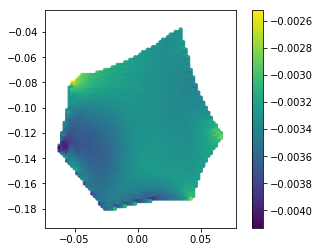

In [55]:
plt.scatter(x,-y,c=ss[:,0,0]-1,s=10
#             ,vmin=0.01,vmax=0.013
           )
plt.axis('scaled')
plt.colorbar()
plt.show()

In [ ]:
S40=np.load('/home/yufengs/SimData/g40_fac20/allMaxS.npy')

plt.scatter(x,-y,c=S40[:,0,0]-1,s=10
#             ,vmin=0.01,vmax=0.013
            ,vmin=-0.0041,vmax=-0.0026
           )
plt.axis('scaled')
plt.colorbar()
plt.show()

In [15]:
a=h5py.File('../SimData/grain_40_fac20.hdf5','r')

tmp=np.array(a['Imgs']['Im3'])
print(np.max(tmp))
np.where(tmp==np.max(tmp))

287


(array([65]), array([131]), array([17]))

<IPython.core.display.Javascript object>


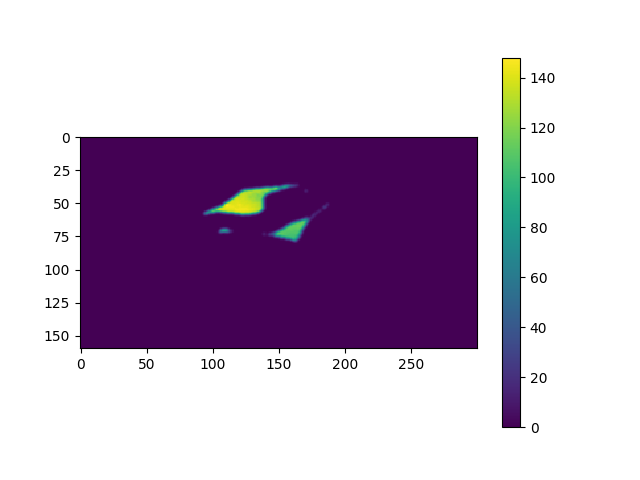

In [62]:
%matplotlib notebook
plt.imshow(a['Imgs']['Im96'][:,:,30])
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


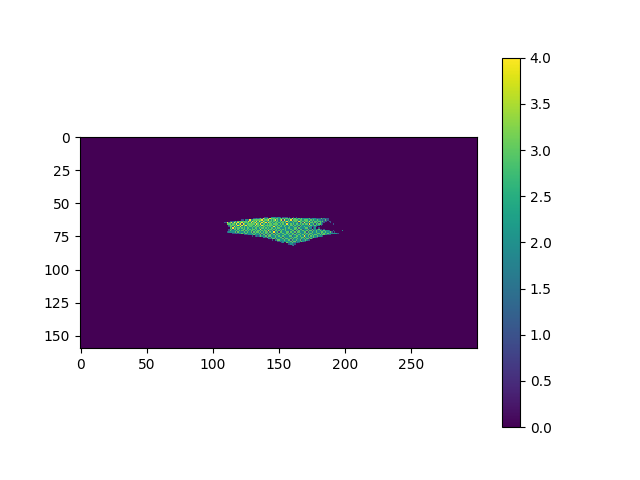

In [21]:
%matplotlib notebook
plt.imshow(trueMaps[3][:,:,17])
plt.colorbar()
plt.show()

In [41]:
import pycuda.gpuarray as gpuarray
from pycuda.autoinit import context
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
dev=cuda.Device(2)
dev.make_context()

import util.RotRep as Rot
from InitStrain import Initializer
from Reconst_GPU import StrainReconstructor_GPU
Cfg=Initializer('ConfigFiles/g40.yml')
peakFile=h5py.File('../SimData/grain_40_fac40.hdf5','r')
Cfg.SetPosOrien(peakFile['Pos'],peakFile['Orien'])
Cfg.Simulate()
recon=StrainReconstructor_GPU( _NumG=Cfg.NumG,
        peakFile=peakFile,
        _Det=Cfg.Det, _Gs=Cfg.Gs, _Info=Cfg.Info, _eng=Cfg.eng)
recon.loadGs()
recon.loadIm()

NumD=len(x)

SD=gpuarray.to_gpu(ss.ravel().astype(np.float32))

XD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.int32)
YD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.int32)
OffsetD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.int32)

MaskD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.bool_)
TrueMaskD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.bool_)

xD=gpuarray.to_gpu(x.astype(np.float32))
yD=gpuarray.to_gpu(y.astype(np.float32))

BlockSize=256
scoreD=gpuarray.empty(NumD,dtype=np.float32)
recon.sim_grain(XD,YD,OffsetD,MaskD,TrueMaskD,
                    xD, yD,recon.afDetInfoD,SD,
                    recon.whichOmegaD,np.int32(NumD),np.int32(Cfg.NumG),np.float32(recon.eng),np.int32(45),recon.LimD,np.int32(5),
                     block=(recon.NumG,1,1),grid=(NumD,1))
recon.hit_func(scoreD,
                XD,YD,OffsetD,MaskD,TrueMaskD,
                recon.MaxIntD,np.int32(recon.NumG),np.int32(NumD),np.int32(45),
                block=(BlockSize,1,1),grid=(int(NumD/BlockSize+1),1))
scoreH=scoreD.get()

<IPython.core.display.Javascript object>


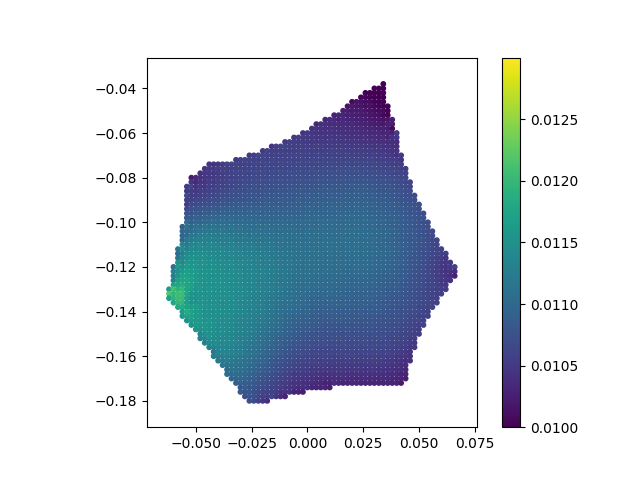

In [30]:
plt.scatter(x,-y,c=ss[:,2,2]-1,s=10
            ,vmin=0.01,vmax=0.013
           )
plt.axis('scaled')
plt.colorbar()

plt.show()

In [44]:
# x40=np.load('/home/yufengs/SimData/g40_fac40/x.npy')
# y40=np.load('/home/yufengs/SimData/g40_fac40/y.npy')
S40=np.load('/home/yufengs/SimData/g40_fac40/allMaxS.npy')
c40=np.load('/home/yufengs/SimData/g40_fac40/allMaxScore.npy')

<IPython.core.display.Javascript object>


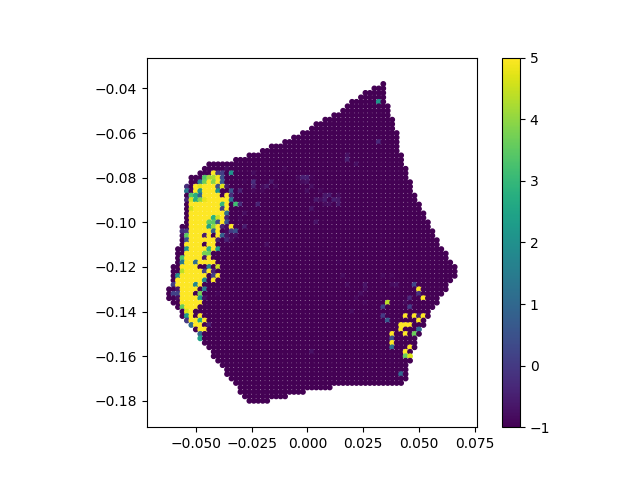

In [57]:
plt.scatter(x,-y,c=scoreH-c40,s=10
            ,vmin=-1,vmax=5
           )
plt.axis('scaled')
plt.colorbar()

plt.show()

In [29]:
import h5py
b=h5py.File('../SimData/grain_40_fac20.hdf5','r')
for ii in range(98):
    tmp=b['Imgs']['Im{:d}'.format(ii)]
    if np.max(tmp)==0:
        print(ii)

19


In [20]:
tmp=np.array(a['Imgs']['Im5'])
print(np.max(tmp))
np.where(tmp==np.max(tmp))

420


(array([76, 76]), array([183, 184]), array([23, 23]))

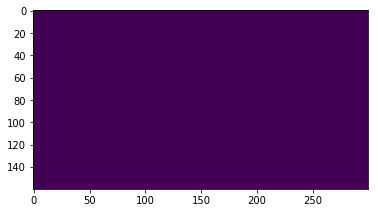

In [23]:
import matplotlib.pyplot as plt
plt.imshow(a['Imgs']['Im5'][:,:,24])
plt.show()